# **Spectrograms & Convolutional NN**

The following code utilizes the [librosa](https://github.com/librosa/librosa) library to extract spectrograms and melgrams from audio files and train a CNN model. When applied to the test set, the model achieves an accuracy of 66% and an F1 (macro) score of 65%.

In [2]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/GitHub/MarineMammalSoundClassification/'
%cd /content/drive/My Drive/GitHub/MarineMammalSoundClassification/

Mounted at /content/drive
/content/drive/My Drive/GitHub/MarineMammalSoundClassification


In [3]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy


## **Extract and Save Spectrograms**

In [4]:
def segment_audio(file_path, segment_length=2.0):
    """
    Segments an audio file into equal parts of specified length with zero padding for the last segment if needed.

    Parameters:
    file_path (str): Path to the input audio file.
    segment_length (float): Length of each segment in seconds. Default is 2.0 seconds.

    Returns:
    list: List of audio segments.
    int: Sample rate of the audio file.
    """
    y, sr = librosa.load(file_path, sr=None)
    segment_samples = int(segment_length * sr)
    total_samples = len(y)

    segments = []
    for start in range(0, total_samples, segment_samples):
        end = start + segment_samples
        segment = y[start:end]
        if len(segment) < segment_samples:
            # Zero-pad the last segment if needed
            segment = np.pad(segment, (0, segment_samples - len(segment)), 'constant')
        segments.append(segment)

    return segments, sr

def display_spectrogram(data):
    """
    Displays a spectrogram from given spectrogram data.

    Parameters:
    data (ndarray): Spectrogram data to display.
    """
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(data, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Linear-frequency power spectrogram')
    plt.show()

def create_spectrogram(segment):
    """
    Creates a spectrogram for a given audio segment.

    Parameters:
    segment (ndarray): Audio segment data.

    Returns:
    ndarray: Spectrogram data in decibels.
    """
    S = librosa.stft(segment)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    # display_spectrogram(S_db)
    return S_db

def create_melgram(segment, sr):
    """
    Creates a mel-spectrogram for a given audio segment.

    Parameters:
    segment (ndarray): Audio segment data.
    sr (int): Sample rate of the audio segment.

    Returns:
    ndarray: Mel-spectrogram data in decibels.
    """
    S = librosa.feature.melspectrogram(y=segment, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)
    # display_spectrogram(S_db)
    return S_db

def resize_spectrogram(data, n):
    """
    Resize a spectrogram to a desired n x n size.

    Parameters:
    data (np.array): Input spectrogram with shape (height, width).
    n (int): Desired size for the output spectrogram (n x n).

    Returns:
    np.array: Resized spectrogram with shape (n, n).
    """
    # Calculate the current size of the spectrogram
    current_height, current_width = data.shape

    # Calculate the zoom factors for height and width to reach the desired size
    zoom_factor_height = n / current_height
    zoom_factor_width = n / current_width

    # Resize the spectrogram
    D_resized = scipy.ndimage.zoom(data, (zoom_factor_height, zoom_factor_width))

    return D_resized

In [11]:
if not os.path.exists('spectrograms'):
   os.makedirs('spectrograms')

In [12]:
def create_pkl_with_spectrograms(set_name, seg_dur, n_size):
    """
    Create pickle files containing spectrograms, mel-spectrograms, class labels, and segment counts
    from audio files segmented into equal parts with zero padding if needed.

    Parameters:
    set_name (str): Name of the dataset directory (train/val/test) located in the 'data_split' directory.
    seg_dur (float): Duration of each segment in seconds.
    n_size (int): Desired size for the output spectrograms and mel-spectrograms (n x n).

    The function generates and saves the following pickle files:
    - 'spectrograms/{seg_dur}_secs/{set_name}_specs.pkl': List of resized spectrograms.
    - 'spectrograms/{seg_dur}_secs/{set_name}_mels.pkl': List of resized mel-spectrograms.
    - 'spectrograms/{seg_dur}_secs/{set_name}_classes.pkl': List of class labels corresponding to the segments.
    - 'spectrograms/{seg_dur}_secs/{set_name}_segments.pkl': List of segment counts per file.
    """
    set_dir = os.path.join("data_split", set_name)
    set_classes = os.listdir(set_dir)
    dirs = [os.path.join(set_dir, c) for c in set_classes]

    spectrograms = []
    melgrams = []
    classes = []
    seg_per_file = []

    # Process each class directory
    for d in dirs:
        class_name = os.path.basename(d)  # Class name (directory name)
        files_list = os.listdir(d)  # List of audio files in the class directory
        for file_name in files_list:
            file_path = os.path.join(d, file_name)  # Full path to the audio file
            segments, sr = segment_audio(file_path, seg_dur)  # Segment the audio file
            seg_per_file.append(len(segments)) # Calculate the number of segments for the audio file

            # Process each segment
            for i, segment in enumerate(segments):
                spectrogram = create_spectrogram(segment)
                r_spectrogram = resize_spectrogram(spectrogram, n_size)
                melgram = create_melgram(segment, sr)
                r_melgram = resize_spectrogram(melgram, n_size)
                classes.append(class_name)
                spectrograms.append(r_spectrogram)
                melgrams.append(r_melgram)

    sub_folder = os.path.join('spectrograms', str(seg_dur) + '_secs')
    if not os.path.exists(sub_folder):
        os.makedirs(sub_folder)

    # Save spectrograms to a pickle file
    with open(os.path.join(sub_folder, set_name + '_specs.pkl'), 'wb') as f:
        pickle.dump(spectrograms, f)

    # Save mel-spectrograms to a pickle file
    with open(os.path.join(sub_folder, set_name + '_mels.pkl'), 'wb') as f:
        pickle.dump(melgrams, f)

    # Save class labels to a pickle file
    with open(os.path.join(sub_folder, set_name + '_classes.pkl'), 'wb') as f:
        pickle.dump(classes, f)

    # Save segment counts per file to a pickle file
    with open(os.path.join(sub_folder, set_name + '_segments.pkl'), 'wb') as f:
        pickle.dump(seg_per_file, f)


In [13]:
for set_name in ['train', 'val', 'test']:
  create_pkl_with_spectrograms(set_name, 2.0, 128)

## **Convolutional Neural Network**

The [TensorFlow](https://www.tensorflow.org/) library was used to set up and train the model.

In [5]:
import pickle
import statistics
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [6]:
def load_data(data_path, classes_path):
    """
    Loads and preprocesses spectrogram data and class labels from pickle files.

    Parameters:
    data_path (str): Path to the pickle file containing spectrogram data.
    classes_path (str): Path to the pickle file containing class labels.

    Returns:
    tuple: A tuple containing:
        - X (np.array): Normalized spectrogram data.
        - y (np.array): One-hot encoded class labels.
        - encoder (LabelEncoder): Fitted LabelEncoder instance for decoding labels.
    """
    with open(data_path, 'rb') as f:
        X = pickle.load(f)
    with open(classes_path, 'rb') as f:
        classes = pickle.load(f)

    # Normalize spectrograms
    X = X / np.max(X)

    encoder = LabelEncoder()
    y = encoder.fit_transform(classes)
    y = to_categorical(y, num_classes=28)

    return np.array(X), np.array(y), encoder

def create_model(input_shape, num_classes):
    """
    Creates and compiles a Convolutional Neural Network (CNN) model.

    Parameters:
    input_shape (tuple): Shape of the input data (height, width, channels).
    num_classes (int): Number of output classes.

    Returns:
    tensorflow.keras.Model: The compiled CNN model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)),
    model.add(layers.MaxPooling2D(pool_size=(2, 2))),
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu')),
    model.add(layers.MaxPooling2D(pool_size=(2, 2))),
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten()),
    model.add(layers.Dense(128, activation='relu')),
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, trainX, trainY, valX, valY, epochs=20, batch_size=32, patience=5):
    """
    Trains the given model using the provided training and validation data.

    Args:
    model (tensorflow.keras.Model): The Keras model to be trained.
    trainX (numpy.ndarray): Training data features.
    trainY (numpy.ndarray): Training data labels.
    valX (numpy.ndarray): Validation data features.
    valY (numpy.ndarray): Validation data labels.
    epochs (int, optional): The number of epochs to train the model. Defaults to 20.
    batch_size (int, optional): The batch size to use during training. Defaults to 32.
    patience (int, optional): The number of epochs with no improvement after which training will be stopped. Defaults to 5.

    Returns:
    tensorflow.keras.callbacks.History: The history object that holds training and validation loss and accuracy values.
    """
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-5)

    history = model.fit(trainX, trainY,
                        validation_data=(valX, valY),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, reduce_lr])

    return history

def plot_history(hist):
    """
    Plots the training and validation accuracy from a Keras model's training history.

    Parameters:
    hist (tensorflow.keras.callbacks.History): History object returned by the `fit` method of a Keras model.

    The function generates a plot showing the training and validation accuracy over epochs.
    """
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()

def reunify_segments(test_predictions, test_true, seg_per_file):
    """
    Reunifies segment-level predictions and true labels into file-level predictions and true labels
    by taking the most common value (mode) of the segments corresponding to each file.

    Parameters:
    test_predictions (list): List of predicted labels for each segment.
    test_true (list): List of true labels for each segment.
    seg_per_file (list): List of segment counts per file, indicating how many segments belong to each file.

    Returns:
    file_predictions (list): List of the most common predicted labels for each file.
    file_true (list): List of the most common true labels for each file.
    """
    index = 0
    file_predictions = []
    file_true = []

    for i in range(len(seg_per_file)):
        # Calculate the new index by adding the number of segments for the current file
        new_index = index + seg_per_file[i]

        # Determine the most common prediction and true label for the current file segments
        most_common_prediction = statistics.mode(test_predictions[index:new_index])
        most_common_true = statistics.mode(test_true[index:new_index])

        # Append the most common values to the file-level lists
        file_predictions.append(most_common_prediction)
        file_true.append(most_common_true)

        # Update the index to the start of the next file's segments
        index = new_index

    return file_predictions, file_true

def evaluate_model(model, testX, testY, testSegments):
    """
    Evaluates the given model using the provided test data, and computes metrics
    both at the segment level and at the file level by reunifying segments.

    Args:
    model (tensorflow.keras.Model): The Keras model to be evaluated.
    testX (numpy.ndarray): Test data features.
    testY (numpy.ndarray): Test data labels (one-hot encoded).
    testSegments (list): List indicating the number of segments per file.

    Returns:
    tuple: A tuple containing:
        - conf_matrix (numpy.ndarray): The confusion matrix of the segment-level test predictions.
        - accuracy (float): The accuracy score of the segment-level test predictions.
        - f1 (float): The F1 score of the segment-level test predictions.
        - reunify_conf_matrix (numpy.ndarray): The confusion matrix of the file-level test predictions.
        - reunify_accuracy (float): The accuracy score of the file-level test predictions.
        - reunify_f1 (float): The F1 score of the file-level test predictions.
    """
    # Make predictions on the test data
    test_predictions = np.argmax(model.predict(testX), axis=1)
    test_true = np.argmax(testY, axis=1)

    # Calculate segment-level metrics
    conf_matrix = confusion_matrix(test_true, test_predictions)
    accuracy = accuracy_score(test_true, test_predictions)
    f1 = f1_score(test_true, test_predictions, average='macro')

    # Reunify segments to get file-level predictions
    test_predictions, test_true = reunify_segments(test_predictions, test_true, testSegments)

    # Calculate file-level metrics
    reunify_conf_matrix = confusion_matrix(test_true, test_predictions)
    reunify_accuracy = accuracy_score(test_true, test_predictions)
    reunify_f1 = f1_score(test_true, test_predictions, average='macro')

    return conf_matrix, accuracy, f1, reunify_conf_matrix, reunify_accuracy, reunify_f1

def save_model(model, file_path):
    """
    Saves the given model to the specified file path.

    Args:
    model (tensorflow.keras.Model): The Keras model to be saved.
    file_path (str): The path where the model will be saved.
    """
    model.save(file_path)

def load_model(file_path):
    """
    Loads a Keras model from the specified file path.

    Args:
    file_path (str): The path from where the model will be loaded.

    Returns:
    tensorflow.keras.Model: The loaded Keras model.
    """
    return tf.keras.models.load_model(file_path)

In [7]:
import utils.tyiannak_utilities as ut
import IPython

def process_pipeline(model_name, specs_or_mels, seg_secs, epochs=20, batch_size=64, patience=5):
    """
    Performs the entire pipeline of processing, training, evaluating, and saving a neural network model.

    Args:
    model_name (str): The name to be used for saving the model and HTML output.
    specs_or_mels (str): Specifies whether to use spectrograms or mel spectrograms.
    seg_secs (int): The segment duration in seconds for which data is prepared.
    epochs (int, optional): The number of epochs to train the model. Defaults to 20.
    batch_size (int, optional): The batch size to use during training. Defaults to 64.
    patience (int, optional): The number of epochs with no improvement after which training will be stopped. Defaults to 5.

    Returns:
    IPython.display.HTML: The HTML object for the classification results report.
    """
    # Load the data
    specs_path = f'spectrograms/{seg_secs}_secs/train_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/train_classes.pkl'

    trainX, trainY, _ = load_data(specs_path, classes_path)

    specs_path = f'spectrograms/{seg_secs}_secs/val_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/val_classes.pkl'

    valX, valY, _ = load_data(specs_path, classes_path)

    # Build the model
    input_shape = trainX.shape[1:]
    num_classes = len(trainY[0])
    model = create_model((input_shape[0], input_shape[1], 1), num_classes)
    history = train_model(model, trainX, trainY, valX, valY, epochs, batch_size, patience)

    plot_history(history)

    # Create directory for saving models if it doesn't exist
    if not os.path.exists('models/CNN'):
        os.makedirs('models/CNN')

    # Save the trained model
    model_path = os.path.join('models/CNN', model_name+'.keras')
    save_model(model, model_path)

    # Load the saved model
    loaded_model = load_model(model_path)

    # Load test data and evaluate the model
    specs_path = f'spectrograms/{seg_secs}_secs/test_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/test_classes.pkl'

    testSegments_path = f'spectrograms/{seg_secs}_secs/test_segments.pkl'
    with open(testSegments_path, 'rb') as f:
        testSegments = np.array(pickle.load(f))


    testX, testY, encoder = load_data(specs_path, classes_path)
    conf_matrix, accuracy, f1, reunify_conf_matrix, reunify_accuracy, reunify_f1 = evaluate_model(loaded_model, testX, testY, testSegments)
    print(f'Test Accuracy: {accuracy*100:.1f}')
    print(f'Test F1 score: {f1*100:.1f}')
    print(f'Reunify Test Accuracy: {reunify_accuracy*100:.1f}')
    print(f'Reunify Test F1 score: {reunify_f1*100:.1f}')

    # Generate and display HTML report for classification results
    output_html = os.path.join('models/CNN', model_name+'.html')
    labels = list(encoder.classes_)
    ut.plotly_classification_results(reunify_conf_matrix, labels, output_html)

    # return IPython.display.HTML(filename=output_html)

Epoch 1/30
90/90 [==============================] - 219s 2s/step - loss: 2.7755 - accuracy: 0.2880 - val_loss: 1.6411 - val_accuracy: 0.5097 - lr: 0.0010
Epoch 2/30
90/90 [==============================] - 225s 2s/step - loss: 2.0417 - accuracy: 0.4064 - val_loss: 1.3736 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 3/30
90/90 [==============================] - 234s 3s/step - loss: 1.5435 - accuracy: 0.5197 - val_loss: 1.2535 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 4/30
90/90 [==============================] - 226s 3s/step - loss: 1.2509 - accuracy: 0.5767 - val_loss: 1.5756 - val_accuracy: 0.5994 - lr: 0.0010
Epoch 5/30
90/90 [==============================] - 223s 2s/step - loss: 1.0672 - accuracy: 0.6296 - val_loss: 1.2187 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 6/30
90/90 [==============================] - 230s 3s/step - loss: 0.9334 - accuracy: 0.6582 - val_loss: 1.8069 - val_accuracy: 0.5441 - lr: 0.0010
Epoch 7/30
90/90 [==============================] - 220s 2s/step - loss: 0.8

/content/drive/MyDrive/GitHub/MarineMammalSoundClassification/utils/tyiannak_utilities.py:75: RuntimeWarning: invalid value encountered in divide
  pre.append(float(c_mat[i, i]) / np.sum(c_mat[:, i]))


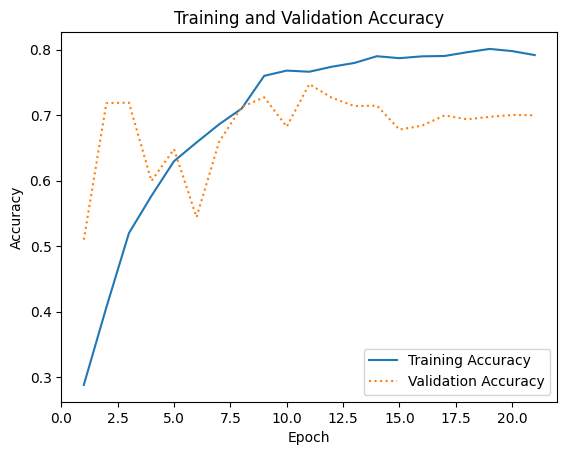

In [8]:
process_pipeline('specs_2.0_30_64_5', 'specs', '2.0', 30, 64, 10)